# Домашнее задание 3
## Сравнение интересов аудитории телеканалов НТВ и Дождь с помощью тематического моделирования LDA

Задача:
Сравнить интересы аудитории телеканолов НТВ и Дождь с помощью методов тематического моделирования
1. Получить данные по аудитории из социальной сети ВК
2. Зарегистрировать приложение, получить app_id, access_token
3. Скачать данные по пользователям в каждой из групп (id групп ВК даны ниже, tvrain_id, ntv_id)
4. Взять небольшую выборку из каждой совокупности телезрителей(около 1000-2000 человек, т.к. 300k-400k слишком много), с которыми работать дальше
5. Обучить LDA модель на их подписках
6. По группам, на которые подписаны эти люди, полуичть ключевые слова групп, на которые они подписаны
7. Получить распределение интересов людей для каждой совокупности, сравнить на графике

In [116]:
import seaborn as sb
import sys  
import pandas as pd
import requests
import numpy as np
import datetime
import time
import pickle
import matplotlib.pyplot as plt
import time
%matplotlib inline

from bs4 import BeautifulSoup as bs
import urllib

In [2]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#### Для использования VK API необходимо создать приложение в VK

1. Создать приложение по адресу https://vk.com/apps?act=manage (кнопка "создать приложение")
2. При создании указать название, описание (можно любые), категория  - прочее. Тип - standalone приложение
3. В настройках получить **app_id**. App_id потребуется для получения access token
4. Авторизовать пользователя (получить access token) можно по адресу: https://vk.com/dev/first_guide, в правилах нас интересует пункт 3 **Авторизация пользователя**
5. После того, как ознакомитесь с авторизацией пользователя, скопируйте в адресную строку такой запрос https://oauth.vk.com/authorize?client_id=5490057&display=page&redirect_uri=https://oauth.vk.com/blank.html&scope=friends&response_type=token&v=5.52, где число **5490057** замените на число, которое получите для вашего **app_id**
6. Нажмите Enter. Откроется окно с запросом прав. В нем отображаются название приложения, иконки прав доступа, и Ваши имя с фамилией. Нажмите «Разрешить». Вы попадете на новую страницу с предупреждением о том, что токен нельзя копировать и передавать третьим лицам. В адресной строке будет URL https://oauth.vk.com/blank.html, а после # Вы увидите дополнительные параметры — access_token, expires_in и user_id. Токен может выглядеть, например, так: 51eff86578a3bbbcb5c7043a122a69fd04dca057ac821dd7afd7c2d8e35b60172d45a26599c08034cc40a
7. Токен — это Ваш ключ доступа. При выполнении определенных условий человек, получивший Ваш токен, может нанести существенный ущерб Вашим данным и данным других людей. Поэтому очень важно не передавать свой токен третьим лицам
8. Поле expires_in содержит время жизни токена в секундах. 86400 секунд — это ровно сутки. Через сутки полученный токен перестанет действовать, для продолжения работы нужно будет получить новый по такому же алгоритму

In [3]:
# use your own app id and respective tokens

# скопируйте сюда ваши app_id и access_token, полученные по методу, описанному выше
app_id = 6745535
access_token = 'd4299526b15f6e823cc1701b9fcd9f3de0fd51dd95899e0ebc0204a40750e4d87c11c570c0a261c8f9a5e' 

# id групп ВК Дождя и НТВ
tvrain_id = 17568841
ntv_id = 28658784

In [4]:
# проверка работы API и авторизации пользователя. Если возникает ошибка, то, возможно, access token необходимо обновить
check_id = 1

# api call and test
def vk_get_response(method, parameters, token):
    url = 'https://api.vk.com/method/' + method + '?' + parameters + '&access_token=' + token
#     print url
    return(requests.get(url).json())

answer = vk_get_response(
    'users.get', 'user_ids={0}&v=4.9&lang=ru'.format(check_id), access_token
)['response']
print(answer[0]['first_name'], answer[0]['last_name'])

Павел Дуров


### Получение подписчиков телеканалов НТВ и Дождь в VK

Получим объекты, которые содержат всю информацию о подпиичиках соответствующих групп (указанных в domains) и сохраним их на диск. Получим в итоге два файла - **ntv_subs** и **tvrain_subs** в формате **.pkl** - питоновский формат хранения данных

In [5]:
domains = ['ntv', 'tvrain']


for group_domain in domains:
    offset = 0
    group_id = group_domain
    fields = """sex,bdate,city,country,home_town,lists,domain,has_mobile,
    contacts,connections,education,universities,followers_count,occupation,last_seen,relation"""
    first_sample = vk_get_response(
        'groups.getMembers', 'group_id={0}&offset={1}&fields={2}&v=4.9&lang=ru'.format(
            group_id, offset, fields
        ), token=access_token
    )
    community_count = first_sample['response']['count']
    community_members = []
    for i in range(community_count // 1000 + 1):
        offset = i * 1000
        try:
            answer = vk_get_response(
                'groups.getMembers', 'group_id={0}&offset={1}&fields={2}&v=4.9&lang=ru'.format(
                    group_id, offset, fields), token=access_token
            )
            print("Offset: ", offset)
        except:
            print("Offset: ", offset, " Error")
        community_members += answer['response']['users']
    save_obj(community_members, '{}_subs'.format(group_domain))

Offset:  0
Offset:  1000
Offset:  2000
Offset:  3000
Offset:  4000
Offset:  5000
Offset:  6000
Offset:  7000
Offset:  8000
Offset:  9000
Offset:  10000
Offset:  11000
Offset:  12000
Offset:  13000
Offset:  14000
Offset:  15000
Offset:  16000
Offset:  17000
Offset:  18000
Offset:  19000
Offset:  20000
Offset:  21000
Offset:  22000
Offset:  23000
Offset:  24000
Offset:  25000
Offset:  26000
Offset:  27000
Offset:  28000
Offset:  29000
Offset:  30000
Offset:  31000
Offset:  32000
Offset:  33000
Offset:  34000
Offset:  35000
Offset:  36000
Offset:  37000
Offset:  38000
Offset:  39000
Offset:  40000
Offset:  41000
Offset:  42000
Offset:  43000
Offset:  44000
Offset:  45000
Offset:  46000
Offset:  47000
Offset:  48000
Offset:  49000
Offset:  50000
Offset:  51000
Offset:  52000
Offset:  53000
Offset:  54000
Offset:  55000
Offset:  56000
Offset:  57000
Offset:  58000
Offset:  59000
Offset:  60000
Offset:  61000
Offset:  62000
Offset:  63000
Offset:  64000
Offset:  65000
Offset:  66000
Offset: 

Offset:  167000
Offset:  168000
Offset:  169000
Offset:  170000
Offset:  171000
Offset:  172000
Offset:  173000
Offset:  174000
Offset:  175000
Offset:  176000
Offset:  177000
Offset:  178000
Offset:  179000
Offset:  180000
Offset:  181000
Offset:  182000
Offset:  183000
Offset:  184000
Offset:  185000
Offset:  186000
Offset:  187000
Offset:  188000
Offset:  189000
Offset:  190000
Offset:  191000
Offset:  192000
Offset:  193000
Offset:  194000
Offset:  195000
Offset:  196000
Offset:  197000
Offset:  198000
Offset:  199000
Offset:  200000
Offset:  201000
Offset:  202000
Offset:  203000
Offset:  204000
Offset:  205000
Offset:  206000
Offset:  207000
Offset:  208000
Offset:  209000
Offset:  210000
Offset:  211000
Offset:  212000
Offset:  213000
Offset:  214000
Offset:  215000
Offset:  216000
Offset:  217000
Offset:  218000
Offset:  219000
Offset:  220000
Offset:  221000
Offset:  222000
Offset:  223000
Offset:  224000
Offset:  225000
Offset:  226000
Offset:  227000
Offset:  228000
Offset: 

In [5]:
community_ntv = load_obj('ntv_subs')
community_tvrain = load_obj('tvrain_subs')

In [6]:
community_ntv_df = pd.DataFrame(community_ntv)
community_tvrain_df = pd.DataFrame(community_tvrain)

Сначала получим всех уникальных подписчиков НТВ и Дождя с помощью unique. Далее с помощью numpy.random необходимо выбрать небольшой sample (например, по 1000 из каждой группы) таких людей и объединить их вместе

In [7]:
ntv_uids = community_ntv_df.uid.unique().tolist()
tvrain_uids = community_tvrain_df.uid.unique().tolist()

In [8]:
print('ntv_uids = ',len(ntv_uids))
print('tvrain_uids = ',len(tvrain_uids))

ntv_uids =  359526
tvrain_uids =  441135


In [9]:
import random
ntv_group_of_uids = ntv_uids    # A sequence or set will work here.
num_to_select = 1000            # Set the number to select here.
ntv_rand_100 = random.sample(ntv_group_of_uids, num_to_select)
ntv_rand_100_df = community_ntv_df[community_ntv_df.uid.isin(ntv_rand_100)]
print(len(ntv_rand_100_df))

tvrain_group_of_uids = tvrain_uids    # A sequence or set will work here.
num_to_select = 1000            # Set the number to select here.
tvrain_rand_100 = random.sample(tvrain_group_of_uids, num_to_select)
tvrain_rand_100_df = community_tvrain_df[community_tvrain_df.uid.isin(tvrain_rand_100)]
print(len(tvrain_rand_100_df))

1000
1000


In [10]:
# получить общий список людей из двух выборок НТВ и Дождя, всего должно быть в итоге около 2000 человек
uids = pd.concat([ntv_rand_100_df,tvrain_rand_100_df])
len(uids)

2000

In [11]:
len(uids.columns)

30

In [47]:
# получить подписки этих пользователей
print_counter = 0
final_data = []
print(print_counter,' - ',final_data)

for uid in uids.uid.tolist():
    try:
        user_subs = vk_get_response(
            'users.getSubscriptions', 'user_id={0}&v=4.9&lang=ru'.format(int(uid)), access_token
        )
        time.sleep(0.3)
        final_data.append(user_subs)
    except:
        print("Error")
    if print_counter % 100 == 0:
        print("{0} profiles done".format(print_counter))
    print_counter += 1

0  -  []
0 profiles done
100 profiles done
200 profiles done
300 profiles done
400 profiles done
500 profiles done
600 profiles done
700 profiles done
800 profiles done
900 profiles done
1000 profiles done
1100 profiles done
1200 profiles done
1300 profiles done
1400 profiles done
1500 profiles done
1600 profiles done
1700 profiles done
1800 profiles done
1900 profiles done


In [52]:
subs_list = []
groups_freq_dict = {}
top_n = 5

for record, uid in zip(final_data, uids):
    try:
        user_subs = record
        if not user_subs.get('response'):
            user_subs = vk_get_response(
                'users.getSubscriptions', 'user_id={0}&v=4.9&lang=ru'.format(int(uid)), access_token
            )
        subs_pd = pd.DataFrame(
            [
                {
                    'groups_count': user_subs['response']['groups'].get('count'),
                    'groups_list': user_subs['response']['groups'].get('items'),
                    'follows_count':user_subs['response']['users'].get('count'),
                    'follows_list': user_subs['response']['users'].get('items'),
                }
            ]
        )

        for group_id in user_subs['response']['groups'].get('items')[:top_n]:
            if groups_freq_dict.get(group_id):
                groups_freq_dict[group_id] += 1
            else:
                groups_freq_dict[group_id] = 1

        subs_pd['subs_count'] = subs_pd['groups_count'] + subs_pd['follows_count']
        subs_list.append(subs_pd)
    except:
#         print(user_subs)
        pass
    if len(subs_list) % 100 == 0:
        print("Processed {0} users".format(len(subs_list)))

Самые популярные группы

In [53]:
sorted([(key, val) for key, val in groups_freq_dict.items()], key=lambda x: x[1], reverse=True)[:5]

[(28658784, 3), (33404310, 3), (34215577, 2), (15755094, 2), (32231484, 2)]

Загрузка постов со стен групп

In [54]:
group_doc_dict = {}
counter = 0
groups_freq_dict_top5 = groups_freq_dict

for group_id, freq in groups_freq_dict_top5.items():
    counter += 1
    try:
        check = vk_get_response(
            'wall.get',
            'owner_id={0}&count=100&fields=post_type,marked_as_ads&&v=4.9&lang=ru'.format(int(group_id) * -1),
            access_token
        )
        check = check['response']
        group_doc = ''
        if check[0] != 0:
            for post in check[1:]:
                if post.get('marked_as_ads') != 1:
                    group_doc += post['text']
        group_doc_dict[group_id] = group_doc
    except:
        print("Response error. Group id {0}".format(group_id))
        print(check)
    if counter % 100 == 0:
        print("{0} groups extracted".format(counter))
    time.sleep(0.3)

100 groups extracted


In [55]:
# сохранить сырые данные по постам групп на диск
save_obj(group_doc_dict, 'group_doc_dict')

In [56]:
from bs4 import BeautifulSoup
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
from pymorphy2 import MorphAnalyzer

In [57]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/dmitry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [58]:
chrs_to_delete = string.punctuation + u'»' + u'«' + u'—' + u'“' + u'„' + u'•' + u'#'
translation_table = {ord(c): None for c in chrs_to_delete if c != u'-'}
units = MorphAnalyzer.DEFAULT_UNITS
morph = MorphAnalyzer(result_type=None, units=units)
PortSt = PorterStemmer()
stopw = set(
    [w for w in stopwords.words(['russian', 'english'])]
    + [u'это', u'году', u'года', u'также', u'етот',
       u'которые', u'который', u'которая', u'поэтому',
       u'весь', u'свой', u'мочь', u'eтот', u'например',
       u'какой-то', u'кто-то', u'самый', u'очень', u'несколько',
       u'источник', u'стать', u'время', u'пока', u'однако',
       u'около', u'немного', u'кроме', u'гораздо', u'каждый',
       u'первый', u'вполне', u'из-за', u'из-под',
       u'второй', u'нужно', u'нужный', u'просто', u'большой',
       u'хороший', u'хотеть', u'начать', u'должный', u'новый', u'день',
       u'метр', u'получить', u'далее', u'именно', u'апрель',
       u'сообщать', u'разный', u'говорить', u'делать',
       u'появиться', u'2016',
       u'2015', u'получить', u'иметь', u'составить', u'дать', u'читать',
       u'ничто', u'достаточно', u'использовать',
       u'принять', u'практически',
       u'находиться', u'месяц', u'достаточно', u'что-то', u'часто',
       u'хотеть', u'начаться', u'делать', u'событие', u'составлять',
       u'остаться', u'заявить', u'сделать', u'дело',
       u'примерно', u'попасть', u'хотя', u'лишь', u'первое',
       u'больший', u'решить', u'число', u'идти', u'давать', u'вопрос',
       u'сегодня', u'часть', u'высокий', u'главный', u'случай', u'место',
       u'конец', u'работать', u'работа', u'слово', u'важный', u'сказать']
)

In [59]:
url_start = 'http[s]?://'
url_end = (
    '(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
)
pattern = url_start + url_end

Обработка слов постов групп - трансформация в "хороший" вид. Нормализация и стэмминг, удаление стоп-слов

In [60]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/dmitry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [61]:
group_clean_doc_dict = {}
counter = 0

for group_id, doc in group_doc_dict.items():
    soup = BeautifulSoup(doc, 'html.parser')
    body = ' '.join(
        [tag.string.replace('\\n', ' ').replace('\\r', ' ')
         for tag in soup.descendants if tag.string]
    )
    body = re.sub('\[.*?\]','', body)
    body = re.sub(pattern,'', body)
    if body != '':
        body_clean = body.translate(translation_table).lower().strip()
        words = word_tokenize(body_clean)
        tokens = []
        # stemming and text normalization
        for word in words:
            if re.match('^[a-z0-9-]+$', word) is not None:
                tokens.append(PortSt.stem(word))
            elif word.count('-') > 1:
                tokens.append(word)
            else:
                normal_forms = morph.normal_forms(word)
                tokens.append(normal_forms[0] if normal_forms else word)
        # remove stopwords and leave unique words only
        tokens = filter(
            lambda token: token not in stopw, sorted(set(tokens))
        )

        # remove all words with more than 3 chars
        tokens = filter(lambda token: len(token) > 3, tokens)
    else:
        tokens = []
    counter += 1
    if counter % 100 == 0:
        print("{0} docs processed".format(counter))
    group_clean_doc_dict[group_id] = tokens

group_clean_doc_dict = {key: list(val) for key, val in group_clean_doc_dict.items()}

100 docs processed


In [62]:
# сохранить обработанные данные на диск
save_obj(group_clean_doc_dict, 'group_doc_dict_clean')

### Обучение LDA модели

In [63]:
from gensim.corpora import TextCorpus
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel

class ListTextCorpus(TextCorpus):

    def get_texts(self):
        for doc in self.input:
            yield doc
                
mycorp = ListTextCorpus(input=group_clean_doc_dict.values())
justlda = LdaModel(
    corpus=mycorp, num_topics=20, passes=12
)

In [64]:
print('LdaModel performance')
for i in range(20):
    terms = justlda.get_topic_terms(i)
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))

LdaModel performance
0 выходить кома хотеться никакой полезный посмотреть необходимый утро новое смотреть
1 район чаять прекрасный данный увидеть приблизительно скорость возможный писать пакет
2 админ человек тело дорога писать родной новое единый цена стекло
3 пара рубль подписчик ноутбук взять телефон мебель чёрный неделя женский
4 жизнь многий россия неделя ребёнок найти вместе новое последний становиться
5 рассказать тысяча право верить бывший выйти найти оказаться снова отец
6 человек способ знать чёрный найти цвета группа страничка красивый совет
7 знать снова хотеться момент сила называть любить человек выбрать часы
8 любить друг хотеться открывать нормальный маленький внутри вера отношение сильный
9 рука друг вместе смочь простой необходимый ждать образ собрать мелкий
10 образ добрый выглядеть прямо комментарий новое купить выбрать матрица внуково
11 жизнь человек добрый получиться праздник начало сразу выйти вместе смочь
12 московский утро фото номер девушка группа готовый дру

In [128]:
# Получить распределение интересов людей для каждой совокупности, сравнить на графике
dummy_dict = {key: 0 for key in range(20)}

group_topics_dict_20 = {
    group_id: dict(list(dummy_dict.items()) + justlda.get_document_topics(mycorp.dictionary.doc2bow(text)))
    for group_id, text in group_clean_doc_dict.items()
}
check_pd_20 = pd.DataFrame.from_dict(group_topics_dict_20, orient='index')
check_pd_20.head(10)
print("Group distribution by the most relevant topic")

data_f = pd.Series.round(check_pd_20.idxmax(axis=1).value_counts() * 1. / len(check_pd_20), 4)
data_f

Group distribution by the most relevant topic


9     0.1262
4     0.1165
5     0.1165
17    0.0777
7     0.0680
11    0.0583
2     0.0485
8     0.0485
0     0.0485
18    0.0388
10    0.0291
12    0.0291
14    0.0291
15    0.0291
3     0.0291
16    0.0291
13    0.0194
6     0.0194
1     0.0194
19    0.0194
dtype: float64

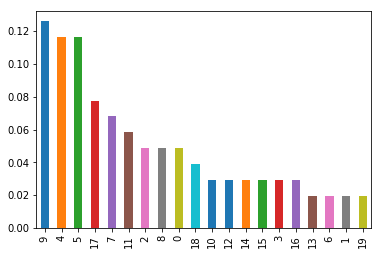

In [127]:
data_f.plot(kind = 'bar',x="index", y="values")

In [66]:
# dump lda model to disk
justlda.save('ldamodel_20_topics')

In [67]:
print("The most typical groups for every topic")
for i in range(20):
    terms = justlda.get_topic_terms(i)
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))
    typical_groups = check_pd_20[i].sort_values(ascending=False).index[:10]
    for g in typical_groups:
        group_info = vk_get_response(
            'groups.getById', 'group_ids={0}&v=4.9&lang=ru'.format(g), access_token
        )
        print(group_info['response'][0]['name'] + ' ' + 'http://vk.com/club' + str(g))
        time.sleep(0.3)
    print()

The most typical groups for every topic
0 выходить кома хотеться никакой полезный посмотреть необходимый утро новое смотреть
Смотри, что я напечатал на 3D-принтере! 3D PRIDE http://vk.com/club48553798
Подслушано Нефтекамск http://vk.com/club59646061
Водолей ( 7 ноября ) http://vk.com/club34528799
Шпильки | Женский Журнал http://vk.com/club29686754
Включи свет I Пошив женской обуви на заказ http://vk.com/club164268908
Cook Good - лучшие рецепты http://vk.com/club39009769
Comedy Radio http://vk.com/club42981815
Super http://vk.com/club46042333
ToFight | БОКС | MMA http://vk.com/club30745740
Sarafan | Fashion Club http://vk.com/club31072900

1 район чаять прекрасный данный увидеть приблизительно скорость возможный писать пакет
Нетипичный Ставрополь http://vk.com/club37725105
Маникюр Нужны модели Минск. Бесплатно/Дешево http://vk.com/club131301656
Cook it! - вкусные рецепты http://vk.com/club32231484
Cook Good - лучшие рецепты http://vk.com/club39009769
ВКазани Поймут | Главное сообщество 

Включи свет I Пошив женской обуви на заказ http://vk.com/club164268908
Cook Good - лучшие рецепты http://vk.com/club39009769
ЛДПР МЫТИЩИ http://vk.com/club173063799
Рецепты http://vk.com/club34451036
Лепра http://vk.com/club30022666
ToFight | БОКС | MMA http://vk.com/club30745740
Sarafan | Fashion Club http://vk.com/club31072900
Bon Appétit | Лучшие рецепты http://vk.com/club32194285

15 ночь литься орех весёлый браться огонь старый грязь слышать белый
Мамины заметки http://vk.com/club26438876
Славянские красоты http://vk.com/club39934740
Auto | Girls | Daily 👑 http://vk.com/club82976122
Медицинские Истории http://vk.com/club28182343
Cook Good - лучшие рецепты http://vk.com/club39009769
ЛДПР МЫТИЩИ http://vk.com/club173063799
ToFight | БОКС | MMA http://vk.com/club30745740
Sarafan | Fashion Club http://vk.com/club31072900
Bon Appétit | Лучшие рецепты http://vk.com/club32194285
Cook it! - вкусные рецепты http://vk.com/club32231484

16 любовь цветочек принцесса красивый город кома тратит